# NO₂ Explanatory Models

## README
### Overview

This notebook develops different machine learning models to fit NO₂ concentration based on various environmental, land use, and socio-economic features. The goal is to attribute key contributors of NO₂ concentration and get the importance of different features.

### Objective

1) Determine appropriate modelling methods to construct the NO₂ explanatory model.
2) Interpret feature importance from the model to identify key contributing factors.

### Workflow

**1. Data Preparation**
   - Load prepared dataset from notebook3, _chapter 1 Merge Multiple Features_. Import dataset format: parquet file.
   - Features including:
      - NO₂ (Target Variable)
      - NO₂ Lag Features 
      - Demographic and Human Activity
      - Road Infrastructure
      - Land Use/Cover Features
      - Climate & Atmospheric features
   - Select interested features based on the correlation matrix in Exploratory Data Analysis and the modelling results.

**2. Modelling and Interpretation**
   - **Selection**: Use **RandomForest** and **Extreme Gradient Boosting (XGBoost)** models to explain NO₂ levels.
   - **Fine-tune**: Fine tune the model hyperparameters using **Randomized Search** method.
   - **Evaluate**: Evaluate different models with metrics like RMSE, R square to determine the best model.
   - **Interpret**: Use **feature importance** (indicated by **SHapley Additive exPlanations, SHAP**) for interpretation.
   - **Visualization**: Produce violin plots to show the importance of different features.
   
### Modelling Results

After fine-tuning the RandomForest and XGBoost model, we get the best hyperparameters in each corresponding model, the model performance of each models is summarised as the following table:


#### Best Model Configuration

After fine-tuning the RandomForest and XGBoost model, we get the best hyperparameters in each corresponding model, the model performance of each models is summarised as the following table:

**Model for Addis Ababa**

| Model Type      | If Scale      | RMSE              | R²        | Best Parameters |
|-----------------|----------     |----------------   |-----------|-----------------|
| Random Forest   | Unscaled      | 1.84221e-05       | 0.21495   |'n_estimators': 200, 'max_depth': 15, <br> 'max_features': 0.5, 'min_samples_leaf': 4|
| XGBoost         | Scale X & y   | 1.84037e-05       | 0.21652   |'subsample': 0.7, 'min_child_weight': 1, <br> 'max_depth': 8, 'eta': 0.01, <br> 'colsample_bytree': 1.0|

**Model for Baghdad**

Due to the large dataset size in Baghdad (over four million samples) and limited computational resources, we reduced the complexity of the hyperparameter search. The resulting model performance is summarized below.

| Model Type      | If Scale      | RMSE              | R²        | Best Parameters |
|-----------------|----------     |----------------   |-----------|-----------------|
| Random Forest   | Unscaled      | 1.32521e-4       | 0.09575   |'n_estimators': 50, 'max_depth': 10, <br> 'max_features': 0.5, 'min_samples_leaf': 500
| XGBoost         | Scale X & y   | 1.31435e-4       | 0.11045   |'subsample': 0.7, 'min_child_weight': 5, <br> 'max_depth': 12, 'eta': 0.01, <br> 'colsample_bytree': 0.7|

#### Driver of NO₂

SHAP value violin plots in chapter 3 gives the intuitive visualization of the feature importance, details see chapter 3 Model Result and Interpretation.  


## 0 Init: Prepare Packages and Configuration

In [ ]:
# Configuration
from pathlib import Path
import sys

CURR_PATH = Path().resolve()            # current file path
REPO_PATH = CURR_PATH.parent            # current repository path
DATA_PATH = REPO_PATH / "data"          # path for saving the data
DEMO_PATH = DATA_PATH / "demo-data"     # path for demo purpose 

SRC_PATH = REPO_PATH / "src"    # path for other sources
sys.path.append(str(SRC_PATH))  # add src to system path to import custom functions

# print(REPO_PATH)

## 1 Models for Addis Ababa

### 1.0 Data Preparation and Feature Selection

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from analysis import* 

Select interested features for model training.

In [ ]:
# Read the data
full_addis_df = pd.read_parquet(DATA_PATH / "temp" / "full_addis_df.parquet", engine="pyarrow")
clean_addis_df = full_addis_df.dropna(subset=["no2_mean", "no2_lag1", "no2_neighbor_lag1"]) 

# select features
features = [
    # variant of no2
    'no2_lag1', 'no2_neighbor_lag1',

    # population
    'pop_sum_m', 
    
    # night time light
    'NTL_mean', 

    # climate data
    'cloud_category',
    'LST_day_mean',
    'temp_mean',

    # road network
    'road_len', 'road_motorway_len',
    'road_trunk_len', 'road_primary_len', 'road_secondary_len',
    'road_tertiary_len', 'road_residential_len', 
    # 'road_share',

    # POI data
    'poi_count', 
    # 'poi_share', 

    # land use
    'lu_industrial_area', 'lu_commercial_area', 'lu_residential_area',  'lu_retail_area', 
    'lu_farmland_area',   'lu_farmyard_area', 
    'fossil_pp_count',
    'landcover_2023',
    # 'lu_industrial_share', 'lu_commercial_share', 'lu_residential_share', 'lu_retail_share', 
    # 'lu_farmyard_share', 'lu_farmland_share',

    'non_built_area',
    'tree_cover_a', 'shrubland_a',
    'grassland_a', 'cropland_a', 'built_up_a', 'sparse_veg_a', 
    'water_bod_a', 'wetland_a',  'unclassified_a', 
    # 'snow_a', 'mangroves_a', 'moss_a',

    'distance_to_primary_road_meters', 'with_primary_road',
]

target = ["no2_mean"]

X = clean_addis_df[features].values
y = clean_addis_df[target].values

# Split training and testing sets (preserving time order, no shuffling)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

y_train = y_train.ravel()  # ravel to 1D
y_test = y_test.ravel()

# Normalize
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).ravel()  # ravel to 1D
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).ravel()

##### Model Input Features  

The final feature vector comprises:

| Driver Category     | Variable(s)                                                                 |
|---------------------|-----------------------------------------------------------------------------|
| Temporal & Spatial  | `no2_lag1`, `no2_neighbor_lag1`                                             |
| Socio-economic      | `pop_sum_m`, `NTL_mean`, `poi_count`                                        |
| Climate             | `cloud_category`, `LST_day_mean`, `temp_mean`                               |
| Built Environment   | `road_len`, `road_motorway_len`, `road_primary_len`, `road_residential_len`, `with_primary_road`, `distance_to_primary_road_meters` |
| Land Use & Cover    | `lu_industrial_area`, `lu_commercial_area`, `lu_residential_area`, `lu_retail_area`, `lu_farmland_area`, `lu_farmyard_area`, `non_built_area` |
| Point Sources       | `fossil_pp_count`                                                           |

This blend of *static*, *temporal*, and *neighborhood* signals enables tree-based models to capture complex non-linear interactions without manual feature engineering.


### 1.1 Random Forest Model

#### Train the Best Model

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import ParameterSampler, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
from tqdm import tqdm
import numpy as np

# Define parameter space
param_dist = {
    "rf__n_estimators":       [100, 200, 300],             
    "rf__max_depth":          [10, 15, 20, None],          
    "rf__min_samples_split":  [10, 20],                  
    "rf__min_samples_leaf":   [5, 10, 20],                   
    "rf__max_features":       ["sqrt", "log2", 0.5, None],            
}

# Custom scorer (lower RMSE is better)
def neg_rmse(y_true, y_pred):
    return -np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(neg_rmse)

# Generate sampled parameter combinations
param_list = list(ParameterSampler(param_dist, n_iter=200, random_state=42))

best_score = -np.inf
best_model = None
best_params = None

print("Running randomized search with progress bar...\n")

# Randomized search with progress bar
for params in tqdm(param_list):
    model = Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("rf", RandomForestRegressor(
            n_jobs              =-1,
            random_state        =42,
            oob_score           =True,
            **params,
        ))
    ])
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring=rmse_scorer, n_jobs=-1)
    mean_score = scores.mean()

    if mean_score > best_score:
        best_score = mean_score
        best_model = model
        best_params = params

print("Best params:", best_params)

# Fit the best model
best_model.fit(X_train, y_train)

from sklearn.metrics import root_mean_squared_error, r2_score
# Evaluate results with RMSE
y_pred = best_model.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Final RMSE:", rmse)
print("R square:", r2)

# Best params: {'n_estimators': 200, 'min_samples_leaf': 4, 'max_features': 0.5, 'max_depth': 15}
# Final RMSE: 1.842214697790195e-05
# R square: 0.21495283791052944

Best params: {'n_estimators': 200, 'min_samples_leaf': 4, 'max_features': 0.5, 'max_depth': 15}

### 1.2 XGBoost Model

In [ ]:
import xgboost as xgb
import numpy as np
from sklearn.model_selection import ParameterSampler

#### <1> Unscale

In [ ]:
# Create DMatrix with real feature names
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=features)

# Define parameter space
param_dist = {
    "max_depth": [6, 8, 10, 12],
    "eta": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0],
    "min_child_weight": [1, 3, 5],
}

evals = [(dtrain, "train"), (dtest, "eval")]

# Hyperparameters
num_round = 300
n_iter_search = 200     # Number of parameter combinations to sample

param_list = list(ParameterSampler(param_dist, n_iter=n_iter_search, random_state=42))

best_rmse = float("inf")
best_params = None
best_model = None

for i, params in tqdm(enumerate(param_list, 1), desc='Progress', total=n_iter_search):
    # print(f"Running parameter set {i}/{n_iter_search}: {params}")

    # Combine with fixed parameters
    xgb_params = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        **params
    }

    evals_result = {}

    bst = xgb.train(
        params=xgb_params,
        dtrain=dtrain,
        num_boost_round=num_round,
        evals=evals,
        evals_result=evals_result,
        verbose_eval=False  # Suppress training log to avoid too much output
    )

    # Get the RMSE of the last evaluation round
    rmse_eval = evals_result["eval"]["rmse"][-1]
    # print(f"RMSE on eval set: {rmse_eval:.5f}")

    if rmse_eval < best_rmse:
        best_rmse = rmse_eval
        best_params = params
        best_model = bst

print("Best params:", best_params)

# Predict using the best model
y_pred = best_model.predict(dtest)

from sklearn.metrics import root_mean_squared_error, r2_score

rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Final RMSE on test set:", rmse)
print("R squared on test set:", r2)

# Best params: {'subsample': 1.0, 'min_child_weight': 3, 'max_depth': 12, 'eta': 0.2, 'colsample_bytree': 1.0}
# Final RMSE on test set: 1.8582815713638704e-05
# R squared on test set: 0.2011995476382038

Best params: {'subsample': 1.0, 'min_child_weight': 3, 'max_depth': 12, 'eta': 0.2, 'colsample_bytree': 1.0}

#### <2> Scale Both X & y between 0-1

In [ ]:
# Create DMatrix with real feature names
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_scaled, feature_names=features)
dtest = xgb.DMatrix(X_test_scaled, label=y_test_scaled, feature_names=features)

# Define parameter space
param_dist = {
    "max_depth": [6, 8, 10, 12],
    "eta": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0],
    "min_child_weight": [1, 3, 5],
}

evals = [(dtrain, "train"), (dtest, "eval")]

# Hyperparameters
num_round = 300
n_iter_search = 200     # Number of parameter combinations to sample

param_list = list(ParameterSampler(param_dist, n_iter=n_iter_search, random_state=42))

best_rmse = float("inf")
best_params = None
best_model = None

for i, params in tqdm(enumerate(param_list, 1), desc='Progress', total=n_iter_search):
    # print(f"Running parameter set {i}/{n_iter_search}: {params}")

    # Combine with fixed parameters
    xgb_params = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        **params
    }

    evals_result = {}

    bst = xgb.train(
        params=xgb_params,
        dtrain=dtrain,
        num_boost_round=num_round,
        evals=evals,
        evals_result=evals_result,
        verbose_eval=False  # Suppress training log to avoid too much output
    )

    # Get the RMSE of the last evaluation round
    rmse_eval = evals_result["eval"]["rmse"][-1]
    # print(f"RMSE on eval set: {rmse_eval:.5f}")

    if rmse_eval < best_rmse:
        best_rmse = rmse_eval
        best_params = params
        best_model = bst

print("Best params:", best_params)

# Predict using the best model
y_pred_scaled = best_model.predict(dtest)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))

from sklearn.metrics import root_mean_squared_error, r2_score

rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Final RMSE on test set:", rmse)
print("R squared on test set:", r2)

# Best params: {'subsample': 0.7, 'min_child_weight': 1, 'max_depth': 8, 'eta': 0.01, 'colsample_bytree': 1.0}
# Final RMSE on test set: 1.840374416831278e-05
# R squared on test set: 0.21652050073565654

Best params: {'subsample': 0.7, 'min_child_weight': 1, 'max_depth': 8, 'eta': 0.01, 'colsample_bytree': 1.0}

#### <3> Only Scale X between 0-1

In [ ]:
# Create DMatrix with real feature names
dtrain = xgb.DMatrix(X_train_scaled, label=y_train, feature_names=features)
dtest = xgb.DMatrix(X_test_scaled, label=y_test, feature_names=features)

# Define parameter space
param_dist = {
    "max_depth": [6, 8, 10, 12],
    "eta": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0],
    "min_child_weight": [1, 3, 5],
}

evals = [(dtrain, "train"), (dtest, "eval")]

# Hyperparameters
num_round = 300
n_iter_search = 200     # Number of parameter combinations to sample

param_list = list(ParameterSampler(param_dist, n_iter=n_iter_search, random_state=42))

best_rmse = float("inf")
best_params = None
best_model = None

for i, params in tqdm(enumerate(param_list, 1), desc='Progress', total=n_iter_search):
    # print(f"Running parameter set {i}/{n_iter_search}: {params}")

    # Combine with fixed parameters
    xgb_params = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        **params
    }

    evals_result = {}

    bst = xgb.train(
        params=xgb_params,
        dtrain=dtrain,
        num_boost_round=num_round,
        evals=evals,
        evals_result=evals_result,
        verbose_eval=False  # Suppress training log to avoid too much output
    )

    # Get the RMSE of the last evaluation round
    rmse_eval = evals_result["eval"]["rmse"][-1]
    # print(f"RMSE on eval set: {rmse_eval:.5f}")

    if rmse_eval < best_rmse:
        best_rmse = rmse_eval
        best_params = params
        best_model = bst

print("Best params:", best_params)

# Predict using the best model
y_pred = best_model.predict(dtest)

from sklearn.metrics import root_mean_squared_error, r2_score

rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Final RMSE on test set:", rmse)
print("R squared on test set:", r2)

# Best params: {'subsample': 1.0, 'min_child_weight': 3, 'max_depth': 12, 'eta': 0.2, 'colsample_bytree': 0.7}
# Final RMSE on test set: 1.8583515833708272e-05
# R squared on test set: 0.2011393558166764

Best params: {'subsample': 1.0, 'min_child_weight': 3, 'max_depth': 12, 'eta': 0.2, 'colsample_bytree': 0.7}

## 2 Models for Baghdad

Considering that we have more than four million samples in Baghdad, fine-tuning the model will take a long time for each iteration. Thus, in Baghdad we only select the most important hyperparameters during the fine-tuning process.

### 2.0 Data Preparation and Feature Selection

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from analysis import* 

Select interested features for model training.

In [ ]:
# Read the data
full_baghdad_df = pd.read_parquet(DATA_PATH / "temp" / "full_baghdad_df.parquet", engine="pyarrow")
clean_bag_df = full_baghdad_df.dropna(subset=["no2_mean", "no2_lag1", "no2_neighbor_lag1"])

# select features
features = [
    # variant of no2
    'no2_lag1', 'no2_neighbor_lag1',

    # population
    'pop_sum_m', 
    
    # night time light
    'NTL_mean', 

    # climate data
    'cloud_category',
    'LST_day_mean', 
    'temp_mean',

    # mobility data
    'TCI',

    # road network
    'road_len', 'road_motorway_len',
    'road_trunk_len', 'road_primary_len', 'road_secondary_len',
    'road_tertiary_len', 'road_residential_len', 
    # 'road_share',

    # POI data
    'poi_count', 
    # 'poi_share', 

    # land use
    'lu_industrial_area', 'lu_commercial_area', 'lu_residential_area',  'lu_retail_area', 
    'lu_farmland_area',   'lu_farmyard_area', 
    'fossil_pp_count',
    'landcover_2023'
    # 'lu_industrial_share', 'lu_commercial_share', 'lu_residential_share', 'lu_retail_share', 
    # 'lu_farmyard_share', 'lu_farmland_share',

]

target = ["no2_mean"]

X = clean_bag_df[features].values
y = clean_bag_df[target].values

# Split training and testing sets (preserving time order, no shuffling)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Normalize
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train).ravel()  # ravel to 1D for xgboost compatibility
y_test_scaled = scaler_y.transform(y_test).ravel()

##### Model Input Features  

The final feature vector comprises:

| Driver Category        | Variable(s)                                                                 |
|------------------------|-----------------------------------------------------------------------------|
| Temporal & Spatial Lag | `no2_lag1`, `no2_neighbor_lag1`                                             |
| Socio-economic Factors | `pop_sum_m`, `NTL_mean`                                                     |
| Environment & Climate  | `cloud_category`, `LST_day_mean`, `temp_mean`                               |
| Mobility & Accessibility | `TCI`, `road_len`, `road_motorway_len`, `road_trunk_len`, `road_primary_len`, `road_secondary_len`, `road_tertiary_len`, `road_residential_len` |
| Human Activity & POI   | `poi_count`                                                                 |
| Land Use & Cover       | `lu_industrial_area`, `lu_commercial_area`, `lu_residential_area`, `lu_retail_area`, `lu_farmland_area`, `lu_farmyard_area`, `landcover_2023` |
| Emission Sources       | `fossil_pp_count`                                                           |

This combination of *static*, *temporal*, *mobility*, and *spatial* features enables tree-based models to capture complex non-linear relationships without requiring manual feature engineering.



### 2.1 Random Forest Model

#### Train the Best Model

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import ParameterSampler, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
from tqdm import tqdm
import numpy as np

# Define parameter space
param_dist = {
    "n_estimators":       [50, 100, 150],
    "max_depth":          [10, 15, 20],
    "min_samples_leaf":   [500, 1000, 2000],
    "max_features":       ["sqrt", 0.3, 0.5],            
}

# Custom scorer (lower RMSE is better)
def neg_rmse(y_true, y_pred):
    return -np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(neg_rmse)

# Generate sampled parameter combinations
param_list = list(ParameterSampler(param_dist, n_iter=10, random_state=42))

best_score = -np.inf
best_model = None
best_params = None

print("Running randomized search with progress bar...\n")

# Randomized search with progress bar
for params in tqdm(param_list):
    model = Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("rf", RandomForestRegressor(
            n_jobs              =-1,
            random_state        =42,
            oob_score           =True,
            **params
        ))
    ])
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring=rmse_scorer, n_jobs=-1)
    mean_score = scores.mean()

    if mean_score > best_score:
        best_score = mean_score
        best_model = model
        best_params = params
print("Best params:", best_params)

# Fit the best model
best_model.fit(X_train, y_train.ravel())
from sklearn.metrics import root_mean_squared_error, r2_score
# Evaluate results with RMSE
y_pred = best_model.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Final RMSE:", rmse)
print("R square:", r2)

# Best params: {'n_estimators': 50, 'min_samples_leaf': 500, 'max_features': 0.5, 'max_depth': 10}
# Final RMSE: 0.00013252161859995474
# R square: 0.095703832724649

Best params: {'n_estimators': 50, 'min_samples_leaf': 500, 'max_features': 0.5, 'max_depth': 10}

### 2.2 XGBoost Model

In [ ]:
import xgboost as xgb
import numpy as np
from sklearn.model_selection import ParameterSampler

#### <1> - Unscale

In [ ]:
# Create DMatrix with real feature names
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=features)

# Define parameter space
param_dist = {
    "max_depth": [6, 8, 10, 12],
    "eta": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0],
    "min_child_weight": [1, 3, 5],
}

evals = [(dtrain, "train"), (dtest, "eval")]

# Hyperparameters
num_round = 300
n_iter_search = 50     # Number of parameter combinations to sample

param_list = list(ParameterSampler(param_dist, n_iter=n_iter_search, random_state=42))

best_rmse = float("inf")
best_params = None
best_model = None

for i, params in tqdm(enumerate(param_list, 1), desc='Progress', total=n_iter_search):
    # print(f"Running parameter set {i}/{n_iter_search}: {params}")

    # Combine with fixed parameters
    xgb_params = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        **params
    }

    evals_result = {}

    bst = xgb.train(
        params=xgb_params,
        dtrain=dtrain,
        num_boost_round=num_round,
        evals=evals,
        evals_result=evals_result,
        verbose_eval=False  # Suppress training log to avoid too much output
    )

    # Get the RMSE of the last evaluation round
    rmse_eval = evals_result["eval"]["rmse"][-1]
    # print(f"RMSE on eval set: {rmse_eval:.5f}")

    if rmse_eval < best_rmse:
        best_rmse = rmse_eval
        best_params = params
        best_model = bst

print("Best params:", best_params)

# Predict using the best model
y_pred = best_model.predict(dtest)

from sklearn.metrics import root_mean_squared_error, r2_score

rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Final RMSE on test set:", rmse)
print("R squared on test set:", r2)

# Best params: {'subsample': 0.7, 'min_child_weight': 5, 'max_depth': 12, 'eta': 0.01, 'colsample_bytree': 0.7}
# Final RMSE on test set: 0.000131575055701303
# R squared on test set: 0.10857593960177803

Best params: {'subsample': 0.7, 'min_child_weight': 5, 'max_depth': 12, 'eta': 0.01, 'colsample_bytree': 0.7}

#### <2> - Both X & y Scale between 0-1

In [ ]:
# Create DMatrix with real feature names
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_scaled, feature_names=features)
dtest = xgb.DMatrix(X_test_scaled, label=y_test_scaled, feature_names=features)

# Define parameter space
# param_dist = {
#     "max_depth": [8, 10, 12],          
#     "eta": [0.05, 0.1, 0.2],           
#     "min_child_weight": [1, 3, 5],     
# }
param_dist = {
    "max_depth": [6, 8, 10, 12],
    "eta": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0],
    "min_child_weight": [1, 3, 5],
}

evals = [(dtrain, "train"), (dtest, "eval")]

# Hyperparameters
num_round = 300
n_iter_search = 50     # Number of parameter combinations to sample

param_list = list(ParameterSampler(param_dist, n_iter=n_iter_search, random_state=42))

best_rmse = float("inf")
best_params = None
best_model = None

for i, params in tqdm(enumerate(param_list, 1), desc='Progress', total=n_iter_search):
    # print(f"Running parameter set {i}/{n_iter_search}: {params}")

    # Combine with fixed parameters
    xgb_params = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        **params
    }

    evals_result = {}

    bst = xgb.train(
        params=xgb_params,
        dtrain=dtrain,
        num_boost_round=num_round,
        evals=evals,
        evals_result=evals_result,
        verbose_eval=False  # Suppress training log to avoid too much output
    )

    # Get the RMSE of the last evaluation round
    rmse_eval = evals_result["eval"]["rmse"][-1]
    # print(f"RMSE on eval set: {rmse_eval:.5f}")

    if rmse_eval < best_rmse:
        best_rmse = rmse_eval
        best_params = params
        best_model = bst

print("Best params:", best_params)

# Predict using the best model
y_pred_scaled = best_model.predict(dtest)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))

from sklearn.metrics import root_mean_squared_error, r2_score

rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Final RMSE on test set:", rmse)
print("R squared on test set:", r2)

# Best params: {'subsample': 0.7, 'min_child_weight': 5, 'max_depth': 12, 'eta': 0.01, 'colsample_bytree': 0.7}
# Final RMSE on test set: 0.00013143625733526347
# R squared on test set: 0.11045567192652805

Best params: {'subsample': 0.7, 'min_child_weight': 5, 'max_depth': 12, 'eta': 0.01, 'colsample_bytree': 0.7}

#### <3> - Only X Scale between 0-1

In [ ]:
# Create DMatrix with real feature names
dtrain = xgb.DMatrix(X_train_scaled, label=y_train, feature_names=features)
dtest = xgb.DMatrix(X_test_scaled, label=y_test, feature_names=features)

# Define parameter space
param_dist = {
    "max_depth": [6, 8, 10, 12],
    "eta": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0],
    "min_child_weight": [1, 3, 5],
}

evals = [(dtrain, "train"), (dtest, "eval")]

# Hyperparameters
num_round = 300
n_iter_search = 50     # Number of parameter combinations to sample

param_list = list(ParameterSampler(param_dist, n_iter=n_iter_search, random_state=42))

best_rmse = float("inf")
best_params = None
best_model = None

for i, params in tqdm(enumerate(param_list, 1), desc='Progress', total=n_iter_search):
    # print(f"Running parameter set {i}/{n_iter_search}: {params}")

    # Combine with fixed parameters
    xgb_params = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        **params
    }

    evals_result = {}

    bst = xgb.train(
        params=xgb_params,
        dtrain=dtrain,
        num_boost_round=num_round,
        evals=evals,
        evals_result=evals_result,
        verbose_eval=False  # Suppress training log to avoid too much output
    )

    # Get the RMSE of the last evaluation round
    rmse_eval = evals_result["eval"]["rmse"][-1]
    # print(f"RMSE on eval set: {rmse_eval:.5f}")

    if rmse_eval < best_rmse:
        best_rmse = rmse_eval
        best_params = params
        best_model = bst

print("Best params:", best_params)

# Predict using the best model
y_pred = best_model.predict(dtest)

from sklearn.metrics import root_mean_squared_error, r2_score

rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Final RMSE on test set:", rmse)
print("R squared on test set:", r2)

# Best params: {'subsample': 0.7, 'min_child_weight': 5, 'max_depth': 12, 'eta': 0.01, 'colsample_bytree': 0.7}
# Final RMSE on test set: 0.00013158384649303515
# R squared on test set: 0.10845681998600609

Best params: {'subsample': 0.7, 'min_child_weight': 5, 'max_depth': 12, 'eta': 0.01, 'colsample_bytree': 0.7}

## 3 Model Result and Interpretation

This chapter interprets the modelling results and explains the key drivers to NO₂ concentration.

### 3.1 Addis Ababa NO₂ Explanatory Model

Data Preparation, including loading and feature engineering.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Prepare Data
full_addis_df = pd.read_parquet(DATA_PATH / "temp" / "full_addis_df.parquet", engine="pyarrow")
clean_addis_df = full_addis_df.dropna(subset=["no2_mean", "no2_lag1", "no2_neighbor_lag1"]) 

target      = ["no2_mean"]
features    = [
    # variant of no2
    'no2_lag1', 'no2_neighbor_lag1',

    # population
    'pop_sum_m', 
    
    # night time light
    'NTL_mean', 

    # climate data
    'cloud_category',
    'LST_day_mean',
    'temp_mean',

    # road network
    'road_len', 'road_motorway_len',
    'road_trunk_len', 'road_primary_len', 'road_secondary_len',
    'road_tertiary_len', 'road_residential_len', 
    'distance_to_primary_road_meters', 'with_primary_road',

    # POI
    'poi_count', 

    # land use
    'lu_industrial_area', 'lu_commercial_area', 'lu_residential_area',  'lu_retail_area', 
    'lu_farmland_area',   'lu_farmyard_area', 
    'fossil_pp_count',
    'landcover_2023',
    'non_built_area',
    'tree_cover_a', 'shrubland_a',
    'grassland_a', 'cropland_a', 'built_up_a', 'sparse_veg_a', 
    'water_bod_a', 'wetland_a',  'unclassified_a', 
]

X = clean_addis_df[features].values
y = clean_addis_df[target].values

# Split training and testing sets (preserving time order, no shuffling)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

y_train = y_train.ravel()  # ravel to 1D
y_test = y_test.ravel()

# Normalize
scaler_X, scaler_y = MinMaxScaler(), MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).ravel()  # ravel to 1D
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).ravel()

100%|===================| 998/1000 [02:16<00:00]        

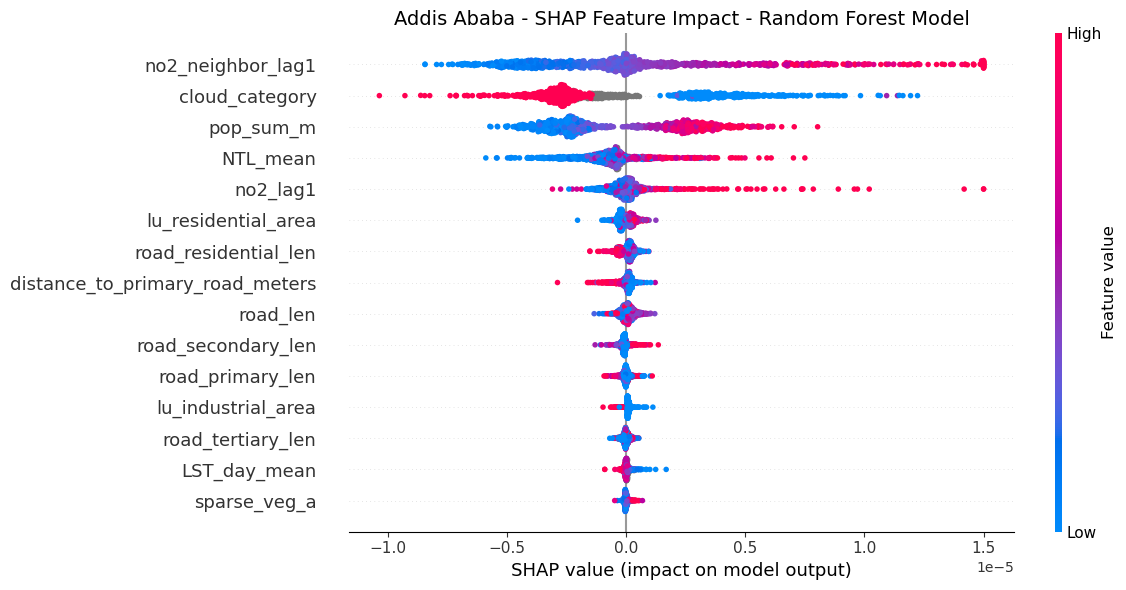

 99%|===================| 987/1000 [00:29<00:00]        

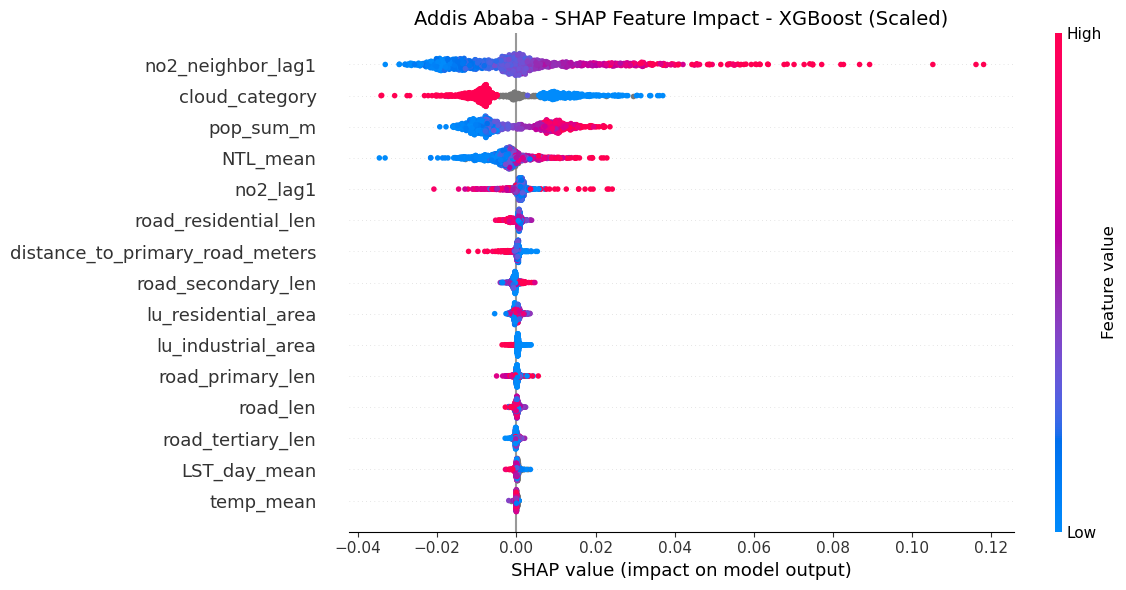

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import xgboost as xgb

from analysis import explain_shap_rf, explain_shap_xgb
# Random Forest Model
rf_params = {'n_estimators': 200, 'min_samples_leaf': 4, 'max_features': 0.5, 'max_depth': 15}

best_model_rf = Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("rf", RandomForestRegressor(
            n_jobs              =-1,
            random_state        =42,
            **rf_params,
        ))
    ])
best_model_rf.fit(X_train, y_train)

# XGBoost Model
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_scaled, feature_names=features)
dtest = xgb.DMatrix(X_test_scaled, label=y_test_scaled, feature_names=features)
evals = [(dtrain, "train"), (dtest, "eval")]

xgb_params = {
        "objective": "reg:squarederror", "eval_metric": "rmse",
        'subsample': 0.7, 'min_child_weight': 1, 'max_depth': 8, 'eta': 0.01, 'colsample_bytree': 1.0
    }

best_model_xgb = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=300,
    evals=evals,
    verbose_eval=False  # Suppress training log to avoid too much output
)

# Show the SHAP value for both models
X_bg                    = pd.DataFrame(X_train, columns=features).sample(n=1000, random_state=42)
X_test_sample           = pd.DataFrame(X_test, columns=features).sample(n=1000, random_state=42)

X_scaled_bg             = pd.DataFrame(X_train_scaled, columns=features).sample(n=1000, random_state=42)
X_test_scaled_sample    = pd.DataFrame(X_test_scaled, columns=features).sample(n=1000, random_state=42)

# Visualize SHAP values on sampled data
explainer, shap_exp = explain_shap_rf(best_model_rf, X_bg, X_test_sample, output_path = DEMO_PATH, max_display=15, clip_range=(-2e-5, 1.5e-5), plot_title="Addis Ababa - SHAP Feature Impact - Random Forest Model", if_save = False)
explainer, shap_exp = explain_shap_xgb(best_model_xgb, X_scaled_bg, X_test_scaled_sample, output_path = DEMO_PATH, max_display=15, clip_range=(-1, 1), plot_title="Addis Ababa - SHAP Feature Impact - XGBoost (Scaled)", if_save = False)


For Addis Ababa, both models consistently indicate that the spatial lag variable (`no2_neighbor_lag1`) is the most influential factor in predicting NO₂ concentrations, highlighting the strong spatial diffusion effect of NO₂ pollution. 
In addition, features representing human activity and meteorological conditions—such as `cloud_category`, `pop_sum_m`, and `NTL_mean` (nighttime light intensity)—also rank among the top predictors in both models, underscoring their critical role in modeling air pollution levels.

Comparatively, the SHAP value distribution in the XGBoost model is significantly wider than that in the Random Forest model (approximately ±0.12 vs. ±1e-5), which is attributed to the feature normalization process and the higher sensitivity of the XGBoost model to input variations. 
Notably, the mean temperature (`temp_mean`) emerges as a relevant factor in the XGBoost model, whereas it is not highlighted in the RF model. Moreover, the XGBoost model shows stronger responses to population and cloud cover, while the RF model emphasizes a more consistent effect from several road-related features (e.g., `road_residential_len`, `road_len`). This suggests that the RF model may be more sensitive to variables with larger numerical scales when features are left unnormalized.

Overall, **both models underscore the importance of spatial lag effects and human activity proxies**. However, differences in the strength and ranking of feature impacts may stem from the combined influence of feature preprocessing methods and model structural differences.


### 3.2 Baghdad NO₂ Explanatory Model

Data Preparation, including loading and feature engineering.

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Prepare Data
full_baghdad_df = pd.read_parquet(DATA_PATH / "temp" / "full_baghdad_df.parquet", engine="pyarrow")
clean_baghdad_df = full_baghdad_df.dropna(subset=["no2_mean", "no2_lag1", "no2_neighbor_lag1"]) 

target      = ["no2_mean"]
features    = [
    # variant of no2
    'no2_lag1', 'no2_neighbor_lag1',

    # population
    'pop_sum_m', 
    
    # night time light
    'NTL_mean', 

    # climate data
    'cloud_category',
    'LST_day_mean', 
    'temp_mean',

    # mobility data
    'TCI',

    # road network
    'road_len', 'road_motorway_len',
    'road_trunk_len', 'road_primary_len', 'road_secondary_len',
    'road_tertiary_len', 'road_residential_len', 

    # POI
    'poi_count', 

    # land use
    'lu_industrial_area', 'lu_commercial_area', 'lu_residential_area',  'lu_retail_area', 
    'lu_farmland_area',   'lu_farmyard_area', 
    'fossil_pp_count',
    'landcover_2023',
]

X = clean_baghdad_df[features].values
y = clean_baghdad_df[target].values

# Split training and testing sets (preserving time order, no shuffling)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

y_train = y_train.ravel()  # ravel to 1D
y_test = y_test.ravel()

# Normalize
scaler_X, scaler_y = MinMaxScaler(), MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).ravel()  # ravel to 1D
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).ravel()

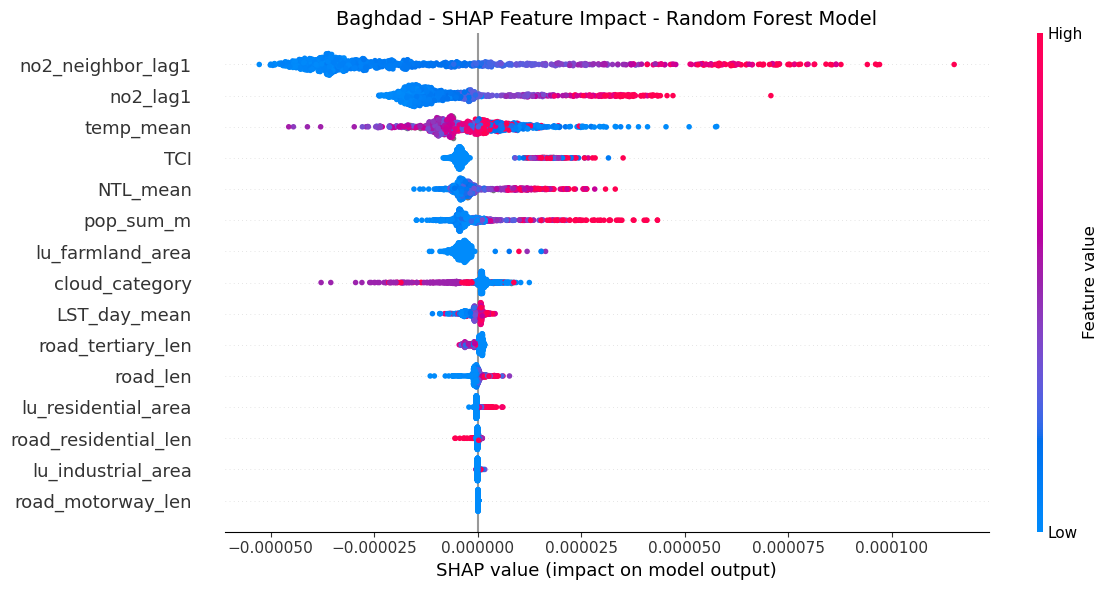

100%|===================| 996/1000 [01:40<00:00]        

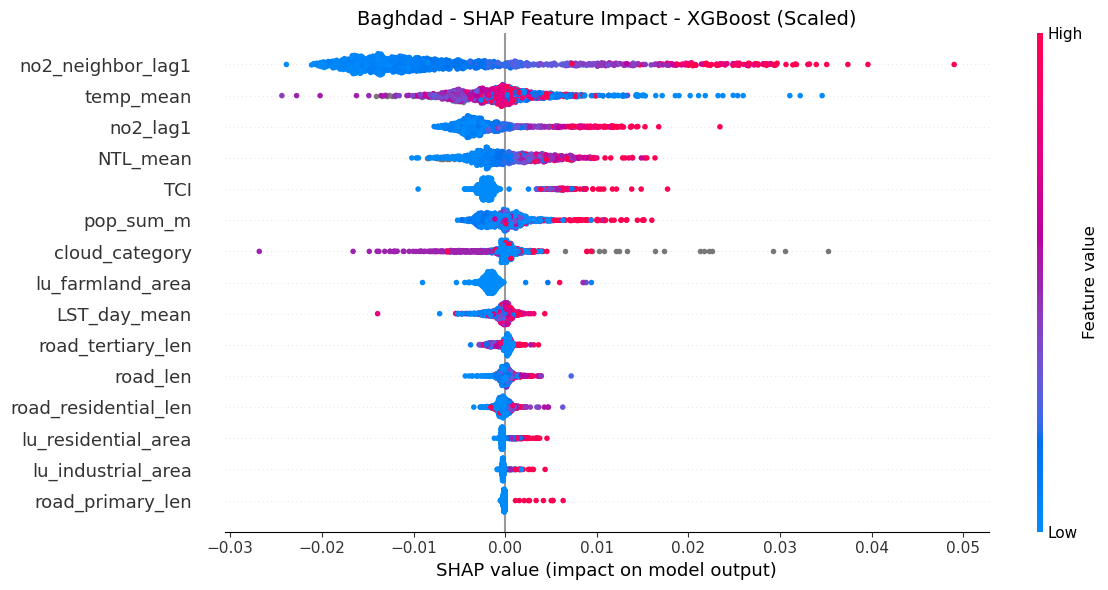

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import xgboost as xgb

from analysis import explain_shap_rf, explain_shap_xgb
# Random Forest Model
rf_params = {'n_estimators': 50, 'min_samples_leaf': 500, 'max_features': 0.5, 'max_depth': 10}

best_model_rf = Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("rf", RandomForestRegressor(
            n_jobs              =-1,
            random_state        =42,
            **rf_params,
        ))
    ])
best_model_rf.fit(X_train, y_train)

# XGBoost Model
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_scaled, feature_names=features)
dtest = xgb.DMatrix(X_test_scaled, label=y_test_scaled, feature_names=features)
evals = [(dtrain, "train"), (dtest, "eval")]

xgb_params = {
        "objective": "reg:squarederror", "eval_metric": "rmse",
        'subsample': 0.7, 'min_child_weight': 5, 'max_depth': 12, 'eta': 0.01, 'colsample_bytree': 0.7
    }

best_model_xgb = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=300,
    evals=evals,
    verbose_eval=False  # Suppress training log to avoid too much output
)

# Show the SHAP value for both models
X_bg                    = pd.DataFrame(X_train, columns=features).sample(n=1000, random_state=42)
X_test_sample           = pd.DataFrame(X_test, columns=features).sample(n=1000, random_state=42)

X_scaled_bg             = pd.DataFrame(X_train_scaled, columns=features).sample(n=1000, random_state=42)
X_test_scaled_sample    = pd.DataFrame(X_test_scaled, columns=features).sample(n=1000, random_state=42)

# Visualize SHAP values on sampled data
explainer, shap_exp = explain_shap_rf(best_model_rf, X_bg, X_test_sample, output_path = DEMO_PATH, max_display=15, clip_range=(-2e-3, 2e-3), plot_title="Baghdad - SHAP Feature Impact - Random Forest Model", if_save = False)
explainer, shap_exp = explain_shap_xgb(best_model_xgb, X_scaled_bg, X_test_scaled_sample, output_path = DEMO_PATH, max_display=15, clip_range=(-1, 1), plot_title="Baghdad - SHAP Feature Impact - XGBoost (Scaled)", if_save = False)


Both models consistently identify temporal-spatial lag features—particularly `no2_neighbor_lag1`— as the most influential driver of NO₂ concentrations, underscoring the importance of pollutant diffusion across adjacent areas. 
Human activity indicators, such as nighttime light intensity (`NTL_mean`), also rank highly, reflecting the strong contribution of nighttime economic activity and urban energy consumption to NO₂ emissions.

In Baghdad, the XGBoost model further underscores the importance of meteorological conditions, particularly average temperature (`temp_mean`), which influences atmospheric mixing and chemical transformation processes. 
Elevated temperatures can reduce pollutant dispersion and intensify local accumulation of NO₂, especially under stagnant conditions. 
Another important feature is the Traffic Congestion Index (`TCI`), which captures real-time mobility pressure in urban areas. 
High TCI values are strongly associated with increased vehicular emissions, making it a direct and interpretable proxy for mobile pollution sources.

While Random Forest also captures some of these patterns, it tends to place relatively higher importance on infrastructure-based features such as road length, likely influenced by its use of unnormalized feature values. 
This difference emphasizes the effect of preprocessing on SHAP distributions: **the normalized inputs in XGBoost yield greater sensitivity to dynamic variables like temperature and congestion, while RF may overemphasize static, high-magnitude features.**

Overall, both models reveal a complex interplay between spatial diffusion, traffic-induced emissions, and meteorological factors in shaping NO₂ concentrations in Baghdad. 
The results also underscore the need to harmonize data preprocessing and interpret model-specific behaviour when assessing feature importance across algorithms.